# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Шаг 1. Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pymystem3 import Mystem
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

In [105]:
way_data = '/datasets/data.csv'

In [4]:
df = pd.read_csv(way_data)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [47]:
df.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

In [48]:
df.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,1.935100e+04
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,1.674223e+05
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,1.029716e+05
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,1.030532e+05
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,1.450179e+05
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,2.034351e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


**Вывод**

В данном датафрэйме можно наблюдать пропущенные значения в столбцах days_employed и total_income, причем если значение пропущено в столбце 'days_employed', то и в столбце 'total_income' оно также отсутствует, исходя из чего, можно предположить, что здесь есть взаимосвязь, а именно: если стоит пропуск в количестве рабочих дней (трудового стажа), то и прибыли у данного человека быть не может, другими словами он никогда не работал.

In [5]:
len(df.loc[(df['days_employed'].isna()) & (df['total_income'].isna())])

2174

действительно, если есть пропуск в одном столбце, то и в другом он также присутствует. Посмотрим какие значения при этом принимает столбец  'тип занятости' (income_type)

In [6]:
df.loc[df['days_employed'].isna()]['income_type'].unique()

array(['пенсионер', 'госслужащий', 'компаньон', 'сотрудник',
       'предприниматель'], dtype=object)

Как видим, все эти люди имеют опыт работы, значит предыдущее предположение не верно. Возможно при внесении/выгрузке данных в датафрэйм произошла ошибка. В любом случае продолжаем проверку данных по каждому столбцу. 

В рабочем режиме я бы еще раз выгрузил данные. 

Хочу понять нет ли некорректных значений в столбцах 'days_employed' и 'income_type' среди непропущенных данных, для этого построю простой график и посмотрю есть ли явные выбросы

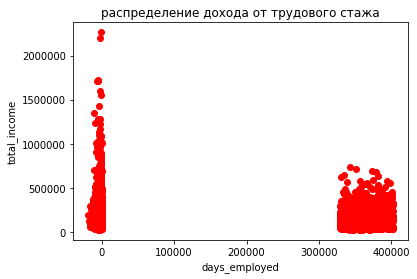

In [51]:
plt.plot(df['days_employed'], df['total_income'], 'ro')
plt.title('распределение дохода от трудового стажа')
plt.xlabel('days_employed')
plt.ylabel('total_income')
plt.show()

Как видно в данных довольно много выбросов и в столбце  'доходы' и ' трудовой стаж' 

In [8]:
print(df['days_employed'].min())
df['days_employed'].max()

-18388.949900568383


401755.40047533

Максимальное значение рабочих часов в столбце если перевести в года, получится что человек без сна и отдыха работал 45 с лишним лет. И также в столбце много значений со знаком '-'. Продолжим исследование других столбцов. 

In [9]:
df['income_type'].unique()

array(['сотрудник', 'пенсионер', 'компаньон', 'госслужащий',
       'безработный', 'предприниматель', 'студент', 'в декрете'],
      dtype=object)

здесь на первый взгляд все хорошо

In [10]:
df['children'].unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5])

Получается интересная вещь: у кого-то '-1' ребенок, а у кого-то целых 20 детей... Продолжаем исследование 

In [11]:
df.loc[df['dob_years'] < 18]['dob_years'].unique()

array([0])

Получается за кредитом обратился младенец. 

In [12]:
df['education'].unique()

array(['высшее', 'среднее', 'Среднее', 'СРЕДНЕЕ', 'ВЫСШЕЕ',
       'неоконченное высшее', 'начальное', 'Высшее',
       'НЕОКОНЧЕННОЕ ВЫСШЕЕ', 'Неоконченное высшее', 'НАЧАЛЬНОЕ',
       'Начальное', 'Ученая степень', 'УЧЕНАЯ СТЕПЕНЬ', 'ученая степень'],
      dtype=object)

Итак данные в этом столбце в разном регистре, надо это исправить. Приведу все значения этого столбца к нижнему регистру

In [13]:
df['family_status'].unique()

array(['женат / замужем', 'гражданский брак', 'вдовец / вдова',
       'в разводе', 'Не женат / не замужем'], dtype=object)

на всякий случай тоже к нижнему регистру приведу

In [14]:
df['gender'].unique()

array(['F', 'M', 'XNA'], dtype=object)

я не в курсе что означает пол 'XNA', можно ли его привести к известным мне значениям? не хотелось бы кого-то обидеть 

In [15]:
df.loc[df['gender'] == 'XNA']

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
10701,0,-2358.600502,24,неоконченное высшее,2,гражданский брак,1,XNA,компаньон,0,203905.157261,покупка недвижимости


В датафрейме одна строка данных с таким значением 

In [16]:
df['debt'].unique()

array([0, 1])

здесь все с первого взгляда все хорошо

In [17]:
df['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

в этом столбце много дубликатов, это нужно поправить

На этом первое знакомство с данными пока закончим и начнем приводить датафрейм в порядок

## Шаг 2. Предобработка данных

### Обработка пропусков

Создам копию датафрейма и все действия, изменяющие данные, буду производить над этой копией. 

In [18]:
df_copy = df.copy()

Для начала разберусь в выбросами в столбце "days_employed", для этого уберу строки со значением NaN, чтобы избавиться от отрицательных значений приведу весь столбец к модулю. Далее посмотрю существует ли связь между возрастом и трудовым стажем, если связь есть то заполню выбросы в трудовом стаже средним значением для такого возраста. Столбец с возрастом также приведу к модулю. 

In [19]:
df_copy['days_employed'] = df_copy['days_employed'].abs()

In [20]:
df_copy['dob_years'] = df_copy['dob_years'].abs()

In [73]:
df_copy['children'] = df_copy['children'].abs()

In [92]:
df_copy['children'].loc[df_copy['children'] > 5] = df_copy['children'].median()

<div class="alert alert-info">
данные по детям поправил. </div>

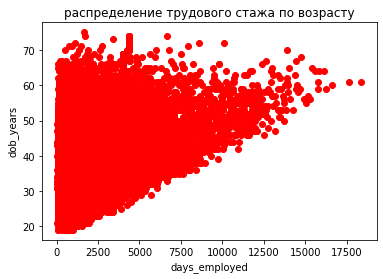

In [50]:
plt.plot(df_copy['days_employed'], df_copy['dob_years'], 'ro')
plt.title('распределение трудового стажа по возрасту')
plt.xlabel('days_employed')
plt.ylabel('dob_years')
plt.show()

Видно, что в возрасте также есть выбросы, согласно нашему датафрейму, 101 человек имеет возраст меньше 15 лет. Для  продолжения работы нужно этот столбец привети в порядок. Сначала  найдем "молодых" пенсионеров и изменим их возраст на 65 лет у мужчин и 60 лет у женщин. 

In [22]:
df_copy['dob_years'].loc[(df_copy['dob_years'] < 15) & (df_copy['income_type'] == 'пенсионер') & (df_copy['gender'] == 'M')] = 65

In [23]:
df_copy['dob_years'].loc[(df_copy['dob_years'] < 15) & (df_copy['income_type'] == 'пенсионер') & (df_copy['gender'] == 'F')] = 60

Остается 82 "малыша" и, за исключением 8 человек, у них нет пропусков в столбце с трудовым стажем, поэтому можно создать столбец с категориями трудового стажа с шагом 500 рабочих дней, затем для каждой такой категории посчитаю средний возраст, приведу его с целому значению и присвою "малышу".  

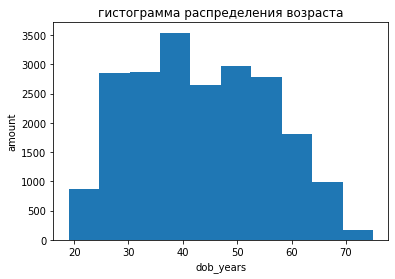

In [52]:
plt.hist(df_copy['dob_years'])
plt.title('гистограмма распределения возраста')
plt.xlabel('dob_years')
plt.ylabel('amount')
plt.show()

In [25]:
df_copy['days_employed_cat'] = 0
days_employed_min, days_employed_max = 0, 500
cat = 1
while days_employed_max < 50000:
    df_copy['days_employed_cat'].loc[(df_copy['days_employed'] >= days_employed_min) & (df_copy['days_employed'] < days_employed_max)] = cat    
    days_employed_min += 500
    days_employed_max += 500
    cat += 1
        

In [26]:
n_days_employed_cat = 1
while n_days_employed_cat <= df_copy['days_employed_cat'].max():
    mean_age = df_copy['dob_years'].loc[(df_copy['days_employed_cat'] == n_days_employed_cat) & (df_copy['dob_years'] > 15) & (df_copy['days_employed_cat'].notna())].mean()
    try: 
        df_copy['dob_years'].loc[(df_copy['days_employed_cat'] == n_days_employed_cat) & (df_copy['dob_years'] < 15) & (df_copy['days_employed_cat'].notna())] = int(mean_age)
    except:
        print(f'в категории {n_days_employed_cat} нельзя вычислить среднее, т.к. недостаточно данных')
    n_days_employed_cat += 1

в категории 35 нельзя вычислить среднее, т.к. недостаточно данных


Теперь посчитаю сколько строк не обработалось

In [27]:
len(df_copy.loc[df_copy['dob_years'] < 15])

7

In [28]:
df_copy.loc[df_copy['dob_years'] < 15]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,days_employed_cat
1890,0,NaN,0,высшее,0,Не женат / не замужем,4,F,сотрудник,0,NaN,жилье,0
4064,1,NaN,0,среднее,1,гражданский брак,1,M,компаньон,0,NaN,ремонт жилью,0
5014,0,NaN,0,среднее,1,женат / замужем,0,F,компаньон,0,NaN,покупка недвижимости,0
8574,0,NaN,0,среднее,1,женат / замужем,0,F,сотрудник,0,NaN,недвижимость,0
12403,3,NaN,0,среднее,1,женат / замужем,0,M,сотрудник,0,NaN,операции с коммерческой недвижимостью,0
13741,0,NaN,0,среднее,1,гражданский брак,1,F,сотрудник,0,NaN,на проведение свадьбы,0
19829,0,NaN,0,среднее,1,женат / замужем,0,F,сотрудник,0,NaN,жилье,0


Итак 7 сток с возрастом "0", с пропусками в стаже и доходе, но все они без долгов по кредитам. Заполню их целым значением среднего возраста людей у которых нет просрочек по кредитам. Хотя можно было бы ими и пожертвовать.

In [29]:
mean_age_without_debt = df_copy['dob_years'].loc[df_copy['debt'] == 0].mean()
df_copy['dob_years'].loc[df_copy['dob_years'] < 15] = int(mean_age_without_debt)

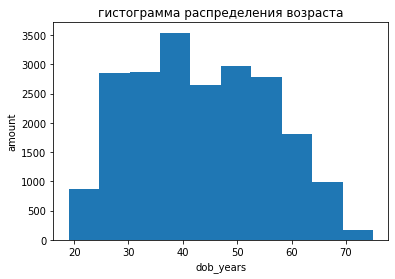

In [53]:
plt.hist(df_copy['dob_years'])
plt.title('гистограмма распределения возраста')
plt.xlabel('dob_years')
plt.ylabel('amount')
plt.show()

Отлично с одним столбцом разобрался. Теперь вернемся к началу и продолжим рабираться с данными в столбце 'days_employed'. Для этого создам столбец с категориями по возрасту и раcчитаю средний трудовой стаж по каждой категории и дальше заполню пропуски его целым значением.

In [31]:
df_copy['age_cat'] = 0
step_age_cat = (df_copy['dob_years'].max() - df_copy['dob_years'].min())/10
age_min = df_copy['dob_years'].min()
cat = 1
while age_min <= df_copy['dob_years'].max():
    df_copy['age_cat'].loc[(df_copy['dob_years'] >= age_min) & (df_copy['dob_years'] < (age_min + step_age_cat))] = cat    
    age_min += step_age_cat
    cat += 1

In [32]:
df_copy['age_cat'].max()

11

In [33]:
n_age_cat = 1
while n_age_cat <= df_copy['age_cat'].max():
    mean_days_employed = df_copy['days_employed'].loc[(df_copy['age_cat'] == n_age_cat) & (df_copy['days_employed'] < 50000) & (df_copy['days_employed'].notna())].mean()
    
    try: 
        df_copy['days_employed'].loc[(df_copy['age_cat'] == n_age_cat) & (df_copy['days_employed'].isna())] = mean_days_employed
        df_copy['days_employed'].loc[(df_copy['age_cat'] == n_age_cat) & (df_copy['days_employed'].notna()) & (df_copy['days_employed'] > 50000)] = mean_days_employed
        
    except:
        print(n_age_cat)
    n_age_cat += 1

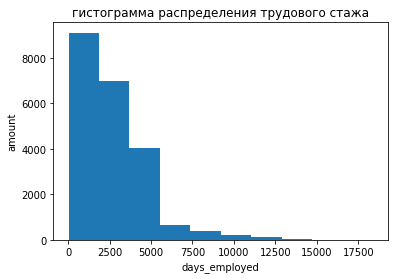

In [55]:
plt.hist(df_copy['days_employed'])
plt.title('гистограмма распределения трудового стажа')
plt.xlabel('days_employed')
plt.ylabel('amount')
plt.show()

С этим столбцом тоже разобрался. Дальше надо заполнить доходы.

Для заполнения пропусков в доходах я буду ориентироваться на 2 столбца: income_type и age_cat. Найду средние значения дохода по типу дохода для каждой возрастной категории и заполню пропуски.

In [35]:
for n_income_type in list(df_copy.loc[df_copy['total_income'].isna()]['income_type'].unique()):
    for n_age_cat in list(df_copy['age_cat'].unique()):
        data = df_copy.loc[(df_copy['income_type'] == n_income_type) & (df_copy['age_cat'] == n_age_cat)]['total_income']
        if True in list(data.isna()):
            mean_income = data.mean()
            if len(list(data.isna())) > 1:
                df_copy['total_income'].loc[(df_copy['income_type'] == n_income_type) & (df_copy['age_cat'] == n_age_cat) & (df_copy['total_income'].isna())] = mean_income
            else:
                df_copy['total_income'].loc[df_copy['total_income'].isna()] = df_copy['total_income'].mean()

               

In [36]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   children           21525 non-null  int64  
 1   days_employed      21525 non-null  float64
 2   dob_years          21525 non-null  int64  
 3   education          21525 non-null  object 
 4   education_id       21525 non-null  int64  
 5   family_status      21525 non-null  object 
 6   family_status_id   21525 non-null  int64  
 7   gender             21525 non-null  object 
 8   income_type        21525 non-null  object 
 9   debt               21525 non-null  int64  
 10  total_income       21525 non-null  float64
 11  purpose            21525 non-null  object 
 12  days_employed_cat  21525 non-null  int64  
 13  age_cat            21525 non-null  int64  
dtypes: float64(2), int64(7), object(5)
memory usage: 2.3+ MB


**Вывод**

Теперь пропуски заполнены и можно продолжать работу.

### Замена типа данных

Для изменения типа данных в столбце воспользуюсь методом astype(). Насколько я понимаю, если строить модель машинного обучения по имеющимся данным, она будет учитывать данные в столбцах education_id, family_status_id и созданные мною days_employed_cat, age_cat  как данные целого типа и чем больше число (категория) тем больший приоритет будет у данной категории, поэтому я бы поменял тип int на object в этих столбцах. Но мы этого не проходили еще, и поэтому оставлю как есть. 

In [37]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   children           21525 non-null  int64  
 1   days_employed      21525 non-null  float64
 2   dob_years          21525 non-null  int64  
 3   education          21525 non-null  object 
 4   education_id       21525 non-null  int64  
 5   family_status      21525 non-null  object 
 6   family_status_id   21525 non-null  int64  
 7   gender             21525 non-null  object 
 8   income_type        21525 non-null  object 
 9   debt               21525 non-null  int64  
 10  total_income       21525 non-null  float64
 11  purpose            21525 non-null  object 
 12  days_employed_cat  21525 non-null  int64  
 13  age_cat            21525 non-null  int64  
dtypes: float64(2), int64(7), object(5)
memory usage: 2.3+ MB


In [38]:
df_copy['days_employed'] = df_copy['days_employed'].astype(int)
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   children           21525 non-null  int64  
 1   days_employed      21525 non-null  int64  
 2   dob_years          21525 non-null  int64  
 3   education          21525 non-null  object 
 4   education_id       21525 non-null  int64  
 5   family_status      21525 non-null  object 
 6   family_status_id   21525 non-null  int64  
 7   gender             21525 non-null  object 
 8   income_type        21525 non-null  object 
 9   debt               21525 non-null  int64  
 10  total_income       21525 non-null  float64
 11  purpose            21525 non-null  object 
 12  days_employed_cat  21525 non-null  int64  
 13  age_cat            21525 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 2.3+ MB


**Вывод**

Тип данных в столбце days_employed изменен на целочисленный

### Обработка дубликатов

При работе с дубликатами первым шагом будет приведение столбцов с интересующими меня данными с нижнему регистру. Для этого использую метод lower(). 

In [39]:
fields = ['education', 'purpose', 'family_status']
for field in fields:
    df_copy[field] = df_copy[field].str.lower()


In [40]:
fields = ['education', 'purpose', 'family_status']
for field in fields:
    print(df_copy[field].unique())



['высшее' 'среднее' 'неоконченное высшее' 'начальное' 'ученая степень']
['покупка жилья' 'приобретение автомобиля' 'дополнительное образование'
 'сыграть свадьбу' 'операции с жильем' 'образование'
 'на проведение свадьбы' 'покупка жилья для семьи' 'покупка недвижимости'
 'покупка коммерческой недвижимости' 'покупка жилой недвижимости'
 'строительство собственной недвижимости' 'недвижимость'
 'строительство недвижимости' 'на покупку подержанного автомобиля'
 'на покупку своего автомобиля' 'операции с коммерческой недвижимостью'
 'строительство жилой недвижимости' 'жилье'
 'операции со своей недвижимостью' 'автомобили' 'заняться образованием'
 'сделка с подержанным автомобилем' 'получение образования' 'автомобиль'
 'свадьба' 'получение дополнительного образования' 'покупка своего жилья'
 'операции с недвижимостью' 'получение высшего образования'
 'свой автомобиль' 'сделка с автомобилем' 'профильное образование'
 'высшее образование' 'покупка жилья для сдачи' 'на покупку автомобиля'
 'рем

**Вывод**

Привел к нижнему регистру данные в интересующих столбцах с помощью цикла for и метода lower(). Далее найду леммы целей кредита

### Лемматизация

In [41]:
m = Mystem()
text = df_copy['purpose']
n_lemmas = []
for i in range(len(df_copy['purpose'].unique())):
    lemmas = m.lemmatize(text[i])
    for j in range(len(lemmas)):
        n_lemmas.append(lemmas[j])

print(Counter(n_lemmas))

Counter({' ': 56, '\n': 38, 'недвижимость': 14, 'покупка': 12, 'автомобиль': 8, 'жилье': 7, 'свадьба': 6, 'на': 6, 'строительство': 5, 'приобретение': 4, 'операция': 4, 'образование': 3, 'сыграть': 3, 'с': 3, 'проведение': 3, 'коммерческий': 3, 'собственный': 3, 'жилой': 2, 'подержать': 2, 'свой': 2, 'дополнительный': 1, 'для': 1, 'семья': 1, 'со': 1})


**Вывод**

Как можно увидеть после подсчета лемматизированных целей кредита, существует не так много уникальных. Могу их выделить и присвоить каждой из них категорию. Единственный момент с недвижимостью, она, в наших целях, бывает жилой и коммерческой, это должны быть разные категории. Возможно выделение двух категорий у автомобилей т.к. есть подержанные и новые, но очень много значений, где указано просто "автомобиль" и не понятно новый он или подержанный, поэтому категория для автомобиля будет одна. 

### Категоризация данных

Итак составлю список с леммами целей. 

In [42]:
purposes_lemmas = ['недвижимость', 'автомобиль', 'жилье', 'свадьба', 'образование', 'жилой', 'коммерческий']

Всего у меня получается 5 уникальных целей и соответственно 5 категорий. Присвою им обозначения.

In [43]:
vehicle = 'автомобиль'
realty_home = ['жилье', 'жилой']
realty_commerce = 'коммерческий'
vedding = 'свадьба'
education = 'образование'

Далее пробегу циклом по столбцу 'purpose' и текст в каждой ячейке лемматизирую. Потом сравню полученные данные со списком purposes_lemmas и при совпадении лемм в ячейке и какой либо из категорий, ее буквенное обозначение будет вносится в новый столбец с категориями целей ("purpose_cat"). 

In [44]:
def add_purpose(row):
    try:
        lemma = m.lemmatize(row['purpose'])
        if 'автомобиль' in lemma:
            return 'vehicle'
        elif 'свадьба' in lemma:
            return 'vedding'
        elif 'коммерческий' in lemma:
            return 'realty_commerce'
        elif 'образование' in lemma:
            return 'education'
        else:
            return 'realty_home'
    except:
        return 'ошибка'

df_copy['purpose_cat'] = df_copy.apply(add_purpose, axis = 1)

In [ ]:
df_copy['purpose_cat'] = ''
num_str = 0
for purpose in df_copy['purpose']:
    lem_purpose = m.lemmatize(purpose)
    if vehicle in lem_purpose:
        df_copy['purpose_cat'][num_str] = 'vehicle'
    elif vedding in lem_purpose:
        df_copy['purpose_cat'][num_str] = 'vedding'
    elif education in lem_purpose:
        df_copy['purpose_cat'][num_str] = 'education'
    elif realty_commerce in lem_purpose:
        df_copy['purpose_cat'][num_str] = 'realty_commerce'
    else:
        df_copy['purpose_cat'][num_str] = 'realty_home'
    
    num_str += 1
        

Далее категоризируем заемщиков по уровню доходу. Для этого выделим 5 категорий: низкий, ниже среднего, средний, выше среднего, высокий. Для начала построим гистограмму распределения доходов.

In [ ]:
plt.hist(df_copy['total_income'].loc[df_copy['total_income'] < 300000], bins = 10)

итак, примем высокий доход все что выше 300 тыс, низкий все что меньше 75 тыс, ниже среднего от 75 тыс до 120 тыс, 120-170 - средний, 170-300 - выше среднего: 

In [100]:
df_copy['income_cat'] = 0
num_str = 0
for income in df_copy['total_income']:
    if income <= 75000:
        df_copy['income_cat'][num_str] = 'low'
    elif income > 75000 and income <= 120000:
        df_copy['income_cat'][num_str] = 'under_medium'
    elif income > 120000 and income <= 170000:
        df_copy['income_cat'][num_str] = 'medium'
    elif income > 170000 and income <= 300000:
        df_copy['income_cat'][num_str] = 'upper_medium'
    else:
        df_copy['income_cat'][num_str] = 'high'
    
    num_str += 1

**Вывод**

Добавил категории по уровню дохода, по возрасту, цели кредита, по трудовому стажу. Данные категории помогли мне выделить группы заемщиков и заполнить пропуски в данных, в дальнейшем выделенные категории помогут в построении модели кредитного скоринга.

## Шаг 3. Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [60]:
with_debt_with_children = df_copy['debt'].loc[(df_copy['children'] != 0) & (df_copy['debt'] == 1)].sum()/
without_debt_with_children = df_copy['debt'].loc[(df_copy['children'] != 0) & (df_copy['debt'] == 0)].sum()
print(f'количество добросоветных плательщиков с детьми - {without_debt_with_children}, количество недобросоветных плательщиков с детьми - {with_debt_with_children}')

количество добросоветных плательщиков с детьми - 0, количество недобросоветных плательщиков с детьми - 678


In [75]:
with_debt_with_children = len(df_copy['debt'].loc[(df_copy['children'] > 0) & (df_copy['debt'] > 0)]) / len(df_copy['debt'].loc[(df_copy['children'] > 0)])
print('Доля должников с детьми: {:.1%}'.format(with_debt_with_children))

Доля должников с детьми: 9.2%


In [93]:
df_chilren_debt = df_copy.groupby('children')['debt'].agg(['count', 'sum', 'mean', lambda x: 1 - x.mean()])
df_chilren_debt.columns = ['Кол-во пользователей', 'Кол-во должников', '% должников', '% НЕдолжников']
df_chilren_debt.style.format({'% должников': '{:.2%}', '% НЕдолжников': '{:.2%}'})

,Кол-во пользователей,Кол-во должников,% должников,% НЕдолжников
children,,,,
0.0,14225,1071,7.53%,92.47%
1.0,4865,445,9.15%,90.85%
2.0,2055,194,9.44%,90.56%
3.0,330,27,8.18%,91.82%
4.0,41,4,9.76%,90.24%
5.0,9,0,0.00%,100.00%


**Вывод**

Получается больше всего должников среди тех у кого есть дети. в данных 9 человек у которых 5 детей и нет просрочек по кредиту, их количество достаточно мало, чтобы строить по ним скоринговую модель.

<div class="alert alert-info">
Исправил </div>

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [95]:
df_married_debt = df_copy.groupby('family_status')['debt'].agg(['count', 'sum', 'mean', lambda x: 1 - x.mean()])
df_married_debt.columns = ['Кол-во пользователей', 'Кол-во должников', '% должников', '% НЕдолжников']
df_married_debt.style.format({'% должников': '{:.2%}', '% НЕдолжников': '{:.2%}'})

,Кол-во пользователей,Кол-во должников,% должников,% НЕдолжников
family_status,,,,
в разводе,1195,85,7.11%,92.89%
вдовец / вдова,960,63,6.56%,93.44%
гражданский брак,4177,388,9.29%,90.71%
женат / замужем,12380,931,7.52%,92.48%
не женат / не замужем,2813,274,9.74%,90.26%


**Вывод**

Получается больше всего должников среди тех кто не в браке или живет в гражданском браке.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [101]:
df_income_debt = df_copy.groupby('income_cat')['debt'].agg(['count', 'sum', 'mean', lambda x: 1 - x.mean()])
df_income_debt.columns = ['Кол-во пользователей', 'Кол-во должников', '% должников', '% НЕдолжников']
df_income_debt.style.format({'% должников': '{:.2%}', '% НЕдолжников': '{:.2%}'})

,Кол-во пользователей,Кол-во должников,% должников,% НЕдолжников
income_cat,,,,
high,1482,106,7.15%,92.85%
low,1865,136,7.29%,92.71%
medium,6860,610,8.89%,91.11%
under_medium,4990,416,8.34%,91.66%
upper_medium,6328,473,7.47%,92.53%


**Вывод**

больше всего должников со средним и выше среднего доходами

- Как разные цели кредита влияют на его возврат в срок?

In [103]:
df_married_debt = df_copy.groupby('purpose_cat')['debt'].agg(['count', 'sum', 'mean', lambda x: 1 - x.mean()])
df_married_debt.columns = ['Кол-во пользователей', 'Кол-во должников', '% должников', '% НЕдолжников']
df_married_debt.style.format({'% должников': '{:.2%}', '% НЕдолжников': '{:.2%}'})

,Кол-во пользователей,Кол-во должников,% должников,% НЕдолжников
purpose_cat,,,,
education,4022,370,9.20%,90.80%
realty_commerce,1315,99,7.53%,92.47%
realty_home,9525,683,7.17%,92.83%
vedding,2348,186,7.92%,92.08%
vehicle,4315,403,9.34%,90.66%


**Вывод**

Больше всего должников среди тех кто берет кредит на образование и автомобиль

после проверки результата присвою имя основного датафрэйма рабочему  

In [ ]:
df = df_copy

## Шаг 4. Общий вывод

Для начала банку нужно понять почему в данных так много пропусков и решить этот вопрос. Процент возврата по кредитам, по рассмотренным категориям, варьируется от 90 до 93 процентов. 

Больший % должников в рассмотренных категориях имеют заемщики: 
1) с детьми;
2) не в браке;
3) в гражданском браке;
4) с целями кредита: образование либо автомобиль; 
5) с доходом средним или выше среднего.

Наименьший % должников среди заемщиков:
1) без детей; 
2) вдовцов;
3) с высоким доходом;
4) берущих кредит на жилье.
  

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл;
- [x]  файл изучен;
- [x]  определены пропущенные значения;
- [x]  заполнены пропущенные значения;
- [x]  есть пояснение, какие пропущенные значения обнаружены;
- [x]  описаны возможные причины появления пропусков в данных;
- [x]  объяснено, по какому принципу заполнены пропуски;
- [x]  заменен вещественный тип данных на целочисленный;
- [x]  есть пояснение, какой метод используется для изменения типа данных и почему;
- [x]  удалены дубликаты;
- [x]  есть пояснение, какой метод используется для поиска и удаления дубликатов;
- [x]  описаны возможные причины появления дубликатов в данных;
- [x]  выделены леммы в значениях столбца с целями получения кредита;
- [x]  описан процесс лемматизации;
- [x]  данные категоризированы;
- [x]  есть объяснение принципа категоризации данных;
- [x]  есть ответ на вопрос: "Есть ли зависимость между наличием детей и возвратом кредита в срок?";
- [x]  есть ответ на вопрос: "Есть ли зависимость между семейным положением и возвратом кредита в срок?";
- [x]  есть ответ на вопрос: "Есть ли зависимость между уровнем дохода и возвратом кредита в срок?";
- [x]  есть ответ на вопрос: "Как разные цели кредита влияют на его возврат в срок?";
- [x]  в каждом этапе есть выводы;
- [x]  есть общий вывод.